# SPX Weekly option simulation
- TODO: Simulation can only handle trade dates that coincide with option expirations. Figure out way to allow for trade dates that are different than expirations.

In [1]:
import pyfolio as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import feather
import socket
if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'
    
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)
from option_simulation import OptionWeeklySimulation, OptionTrades, SimulationParameters, OptionSimulation
from spx_data_update import UpdateSP500Data
from option_utilities import perf_stats, get_theoretical_strike, plot_performance_quad

# Simulation Parameters
- Choose option_duration in days
- Choose n minimum number of contracts needed
- Choose z-score
Simulation assumes options are held to expiration so trade dates ae determined by option durations.

In [2]:
%time opt_sim = OptionWeeklySimulation(update_simulation_data=False)
option_type = 'P'
n = 2
option_duration = pd.Timedelta('20 days')
raw_df = opt_sim.trade_sim(-1, option_duration, option_type)

Feather file not updated
CPU times: user 2.41 s, sys: 1.19 s, total: 3.59 s
Wall time: 1.41 s
Running Simulation - Weekly Options - | Z-score -1 | Duration 20 Days | Option Type:P


In [3]:
# Find sell_by_date - Date at which there at at least n expiries thereafter
n = 6
grouping = raw_df.groupby('quote_date')
quote_dates = []
number_exp = []
for group in grouping:
    number_exp.append(len(group[1]['expiration'].unique()))
    quote_dates.append(group[1]['quote_date'].unique())
# Find last instance of only one expiry
sell_by_date = quote_dates[::-1][number_exp[::-1].index(n)-1][0]
raw_df_shrt = raw_df[raw_df['quote_date'] >= sell_by_date]
print(sell_by_date)

2014-07-03T00:00:00.000000000


In [4]:
expiries_by_quote_date = raw_df_shrt.groupby('quote_date').\
                         apply(lambda x: pd.DatetimeIndex(x['expiration'].unique()).sort_values())

trade_dates_list = []
for i, (idx, dte) in enumerate(zip(expiries_by_quote_date.index, expiries_by_quote_date)):
    if i == 0:
         trade_dates_list.append(idx)
    if idx == trade_dates_list[-1]:
        theoretical_exp = trade_dates_list[-1] + option_duration
        days_diff = dte - theoretical_exp
        next_trade_date = days_diff[days_diff >= pd.Timedelta('0 day')].min() +  theoretical_exp
        trade_dates_list.append(next_trade_date)
trade_dates = pd.DatetimeIndex(trade_dates_list)[:-1]
expiration_dates = pd.DatetimeIndex(trade_dates_list)[1:]
assert(trade_dates[0] == sell_by_date)

In [5]:
zero_yields = opt_sim.usZeroYldCurve.get_zero_4dates(as_of_dates=trade_dates,
                                                          maturity_dates=expiration_dates,
                                                          date_adjust=True)
zero_yields = pd.Series(data=zero_yields, index=trade_dates, name='zeros')
zero_yields = pd.concat([zero_yields,
                         pd.Series(data=expiration_dates, index=zero_yields.index,
                                   name='expiration_date')], axis=1)
trade_inputs = opt_sim.sim_param.reindex(trade_dates)
trade_inputs[zero_yields.columns] = zero_yields
spot_price = trade_inputs.loc[:, 'sp500_close'].values
dividend_yield = trade_inputs.loc[:, 'Yield Value'].values / 100
sigma = trade_inputs.loc[:, 'vix_index'].values / 100
risk_free = trade_inputs.loc[:, 'zeros'].values / 100
option_strikes_theoretical = get_theoretical_strike(trade_dates,
                                                    expiration_dates,
                                                    spot_price, risk_free, [opt_sim.zscore],
                                                    dividend_yield, sigma)                                                                            
trade_inputs['strike_theoretical'] = option_strikes_theoretical

In [6]:
sim_dates_live = pd.date_range(trade_dates[0], opt_sim.sim_dates_all[-1], freq='B')
sim_dates_live = sim_dates_live.intersection(opt_sim.sim_dates_all)
# Simulation date cannot go beyond last expiry
if sim_dates_live[-1] >= expiration_dates[-1]:
    last_sim_date_idx = sim_dates_live.get_loc(expiration_dates[-1])
    sim_dates_live = sim_dates_live[:last_sim_date_idx]
    
trade_dates = trade_dates[trade_dates< sim_dates_live[-1]]
expiration_dates = expiration_dates[trade_dates< sim_dates_live[-1]]

In [7]:
%time dtf_trades = OptionSimulation.simulation_loop(option_type, \
                                                    sim_dates_live, \
                                                    trade_dates, \
                                                    trade_inputs, \
                                                    opt_sim.usZeroYldCurve, \
                                                    raw_df_shrt)
sim_output = SimulationParameters(dtf_trades, opt_sim.zscore, sim_dates_live, 'P', str(option_duration.days) + ' days')
opt_trade = OptionTrades(sim_output, leverage=2)
performance = opt_trade.performance_summary
# perf = pd.concat(performance, axis=1, sort=False)
# opt_trade.returns
performance

CPU times: user 22.6 s, sys: 154 ms, total: 22.7 s
Wall time: 22.8 s


,20 daysP-1L2.0
StartDate,"Jul 03, 2014"
EndDate,"Apr 02, 2019"
Leverage,2
ZScore,-1
Avg_Days,11.7002
annual_return,0.074284
annual_volatility,0.095263
sharpe_ratio,0.800569
calmar_ratio,0.558661
stability_of_timeseries,0.967981


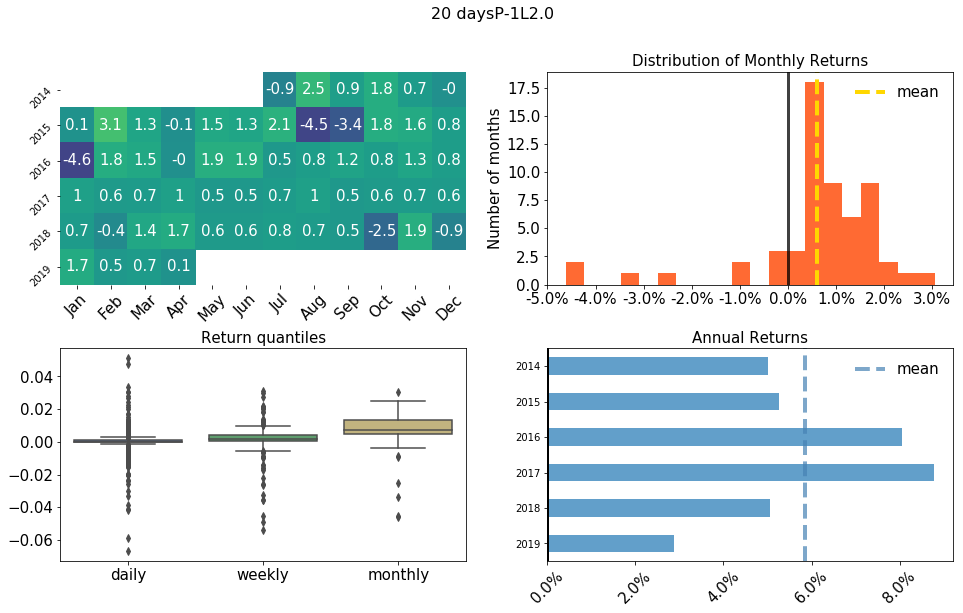

In [8]:
plot_performance_quad(opt_trade.returns, font_size=15)